In [5]:
%matplotlib widget
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.dct import colxfm

# 8 The Lapped Bi-orthogonal Transform (LBT)

<!-- sorry for the nasty HTML, markdown is bad for figures -->

<figure style="text-align: center">
<div class="row">
<figure class="col-md-4 col-md-offset-1">
<img src="figures/lbt.png" style="max-height: 350px" />
<figcaption>(a) Lapped Bi-orthogonal Transform</figcaption>
</figure>

<figure class="col-md-5 col-md-offset-1">
<img src="figures/pot.png" style="max-height: 350px" />
<figcaption>(b) Photo Overlap Transform and a DCT</figcaption>
</figure>
</div>
<div class="row">
<figcaption>
<br />

Figure 4: (a) An LBT transforms overlapping sections of `X` to create `Y`. (b) In some cases
this can be interpreted as pre-filtering with a POT, followed by a DCT.</figcaption></div></figure>

One of the difficulties with the DCT is that it processes each block separately and hence
does not take advantage of any correlation between blocks. A possible solution to this is
to use a _Lapped Bi-orthogonal Transform (LBT)_. These transform overlapping blocks in `X`
to generate smaller non-overlapping blocks in `Y`. In the left-hand figure above, 16 values
in `X` are used to generate each set of 8 values in `Y`.

LBTs are quite complicated to derive and analyse: however one of the most popular forms<sup>3</sup>
can also be represented as a pre-filtering operation before performing the DCT described
in the previous section.
In this case the pre-filtering (or post-filtering for the reverse
operation) is sometimes known as a _Photo Overlap Transform or POT_. A POT followed
by a DCT is then equivalent to a particular type of LBT.

The right-hand figure above demonstrates this. The POT is first performed on a section
of data `X`, shifted by `N/2`, so that it runs across the block boundaries of the subsequent
DCT. Ignoring this block shift for a moment, the forward operation for a 2D image `X` is:


$$Y = C ∗ Pf ∗ X ∗ Pf ′ ∗ C′$$

or in reverse

$$ X = Pr′ ∗ C′ ∗ Y ∗ C ∗ Pr $$

<hr />
<small><sup>3</sup>The type-II fast lapped (bi-)orthogonal transform, or LOT-II</small>

## 8.1 Applying the LBT to images

In [6]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

The pre-filtering `Pf ∗ X ∗ Pf′` (with the correct block shift) is straightforward in Python:

```python
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
```

This is followed by the DCT `C` as before. In the reverse operation, the inverse DCT `C’` is
performed first, followed by Pr’:
```python
Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
```

We have provided a function `pot_ii(N, s)` which will generate a forward (pre-filtering,
`Pf`) and reverse (post-filtering, `Pr`) matrix of size `N` with scaling factor `s`.

In [7]:
from cued_sf2_lab.lbt import pot_ii
from cued_sf2_lab.dct import dct_ii
from matplotlib import pyplot as plt

Edit your code
for performing DCT analysis so that it can pre-filter `X` with `Pf` before the forward DCT,
then post-filter `Z` with `Pr` after the inverse DCT. Confirm that, without quantisation, this
correctly recreates the original image, i.e. `Zp = X`. Use `Pf, Pr = pot_ii(N)` with the
default scaling value `s`.

Maximum error is: 7.247535904753022e-13


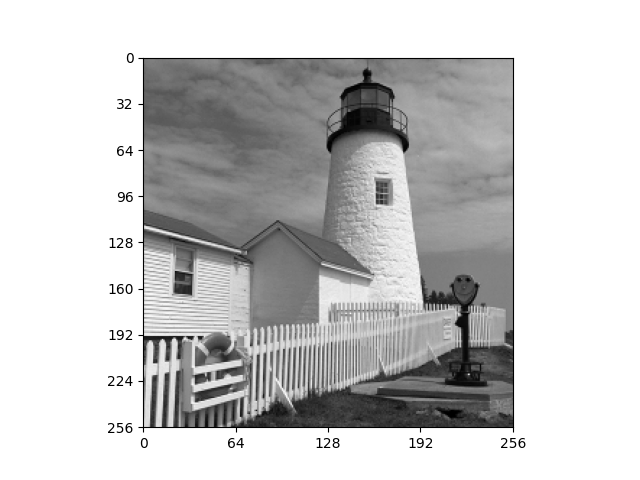

In [8]:
# your code here
N=8
C8 = dct_ii(8)

Pf, Pr = pot_ii(N)
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

Y = colxfm(colxfm(Xp, C8).T, C8).T

Z = colxfm(colxfm(Y.T, C8.T).T, C8.T)

Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)

fig, ax = plt.subplots()
plot_image(Zp, ax=ax);

max_err = np.max(abs(X-Zp))
print(f"Maximum error is: {max_err}")

## 8.2 Quantisation and coding efficiency

The scaling factor `s` determines the degree of bi-orthogonality. If `s = 1` then Pf is the same
as Pr, otherwise `1 < s < 2` weights the relative contributions of `Pf` and `Pr` un-equally.

<div class="alert alert-block alert-danger">

For an 8 × 8 DCT, try implementing an LBT with POT scaling factors varying from $1$
to $2$ ($\sqrt{2}$ is often a good choice). In each case find the quantisation step which makes
the rms error match the directly quantised image. Note the compression ratios and find
the scaling factor which maximises these. Also note the visual features in these images.</div>

{1.0: 23.349609375, 1.01: 23.466796875, 1.02: 23.525390625, 1.03: 23.642578125, 1.04: 23.701171875, 1.05: 23.818359375, 1.06: 23.876953125, 1.07: 23.994140625, 1.08: 24.052734375, 1.09: 24.111328125, 1.1: 24.228515625, 1.11: 24.287109375, 1.12: 24.345703125, 1.1300000000000001: 24.404296875, 1.1400000000000001: 24.462890625, 1.1500000000000001: 24.521484375, 1.1600000000000001: 24.638671875, 1.1700000000000002: 24.697265625, 1.1800000000000002: 24.755859375, 1.1900000000000002: 24.814453125, 1.2000000000000002: 24.873046875, 1.2100000000000002: 24.931640625, 1.2200000000000002: 24.990234375, 1.2300000000000002: 25.048828125, 1.2400000000000002: 25.107421875, 1.2500000000000002: 25.166015625, 1.2600000000000002: 25.224609375, 1.2700000000000002: 25.283203125, 1.2800000000000002: 25.341796875, 1.2900000000000003: 25.400390625, 1.3000000000000003: 25.458984375, 1.3100000000000003: 25.458984375, 1.3200000000000003: 25.517578125, 1.3300000000000003: 25.576171875, 1.3400000000000003: 25.6347

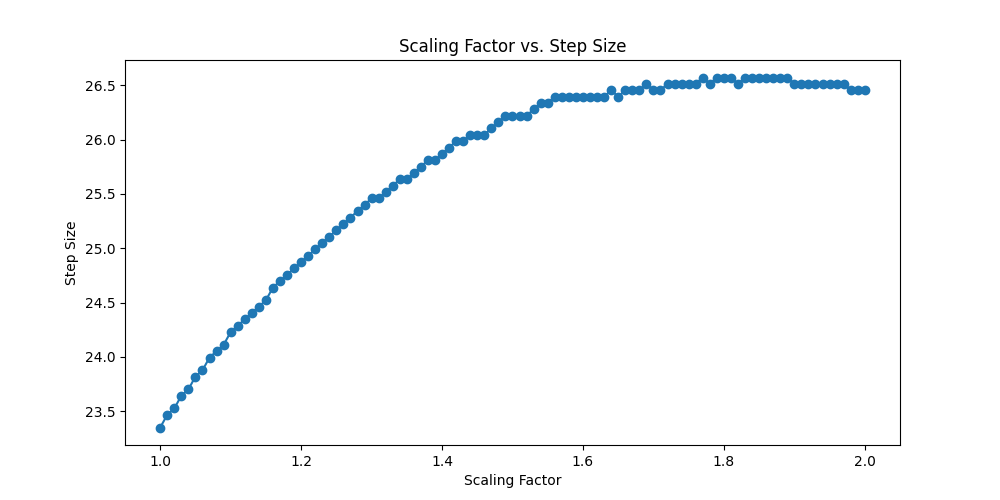

In [9]:
# your code here
# 1 Set quantisation step sizes to match the rms error of directly quantised image with step size of 17
# 2 Calculate compression ratio for each step size
# 3 Show each image with caption of comp. ratio and quantisation step size
from cued_sf2_lab.laplacian_pyramid import bpp, quantise

scaling_factors = np.arange(1, 2.01, 0.01)

def gen_Z_quant_lbt(X, step_size, C, s):
    N = C.shape[0]  # Assuming C is the DCT matrix
    Pf, Pr = pot_ii(N, s)
    t = np.s_[N//2:-N//2]  # Slicing for the transformation

    Xp = X.copy()
    Xp[t, :] = colxfm(Xp[t, :], Pf)
    Xp[:, t] = colxfm(Xp[:, t].T, Pf).T

    Y = colxfm(colxfm(Xp, C).T, C).T
    Yq = quantise(Y, step_size)

    Z = colxfm(colxfm(Yq.T, C.T).T, C.T)
    Zp = Z.copy()
    Zp[:, t] = colxfm(Zp[:, t].T, Pr.T).T
    Zp[t, :] = colxfm(Zp[t, :], Pr.T)

    return Zp

def compute_err(X, step_size, C, s):
    Zp = gen_Z_quant_lbt(X, step_size, C, s)
    return np.std(X - Zp)

def find_step_equal_rms(X, C, s):
    target_err = np.std(X - quantise(X, 17))

    # Vectorized search using binary search for efficiency
    low, high = 15, 30
    while high - low > 0.1:
        mid = (low + high) / 2
        err = compute_err(X, mid, C, s)

        if err < target_err:
            low = mid
        else:
            high = mid

    return (low + high) / 2

step_sizes = {}
for i in scaling_factors:
    step_sizes[i] = find_step_equal_rms(X, C8, i)

print(step_sizes)

# Show a graph of scaling factor versus step size
plt.figure(figsize=(10, 5))
plt.plot(scaling_factors, [step_sizes[i] for i in scaling_factors], marker='o')
plt.xlabel('Scaling Factor')
plt.ylabel('Step Size')
plt.title('Scaling Factor vs. Step Size')
plt.show()



In [10]:
# Repeat dctbpp() function from notebook 7
def dctbpp(Yr, N):
    m, n = Yr.shape
    if m % N != 0 or n % N != 0:
        raise ValueError('Height/width of Yr not multiple of N')
    
    entropy_sum = 0
    for i in range(0, m, m//N):
        for j in range(0, n, n//N):
            sub_img = Yr[i:i+m//N, j:j+n//N]
            sub_img_ent = bpp(sub_img) * sub_img.size
            entropy_sum += sub_img_ent

    return entropy_sum

In [11]:
def gen_Y_quant_lbt(X, step_size, C, s):
    N = C.shape[0]  # Assuming C is the DCT matrix
    Pf, Pr = pot_ii(N, s)
    t = np.s_[N//2:-N//2]  # Slicing for the transformation

    Xp = X.copy()
    Xp[t, :] = colxfm(Xp[t, :], Pf)
    Xp[:, t] = colxfm(Xp[:, t].T, Pf).T

    Y = colxfm(colxfm(Xp, C).T, C).T
    Yq = quantise(Y, step_size)

    return Yq

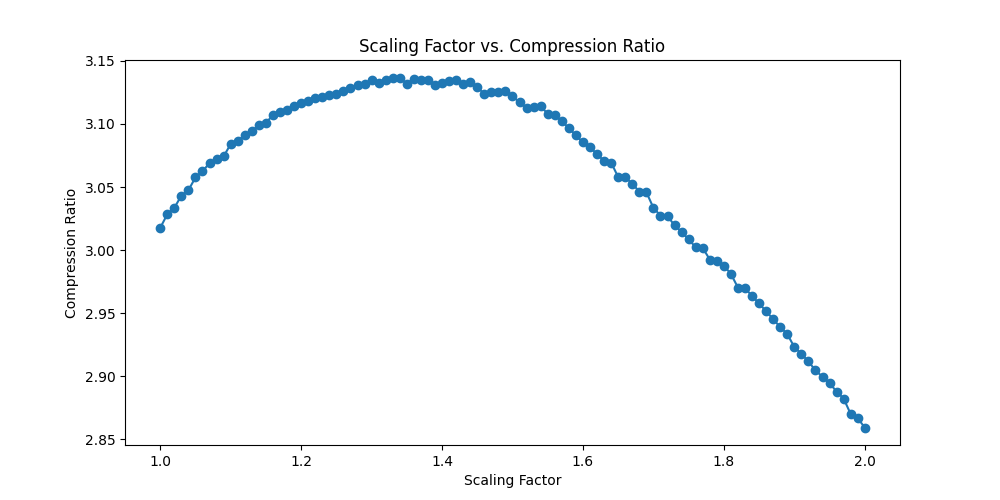

In [12]:
# Generate images, calculate entropies, and compression ratios
from cued_sf2_lab.dct import regroup

Y = []
entropies = []
comp_ratios = []
N = 8

X_quant = quantise(X, 17)
X_quant_ent = bpp(X_quant) * X_quant.size

for i in scaling_factors:
    Yq = gen_Y_quant_lbt(X, step_sizes[i], C8, i)
    Y.append(Yq)
    Yr = regroup(Yq, N)
    entropy = dctbpp(Yr, N)
    entropies.append(entropy)
    comp_ratios.append(X_quant_ent / entropy)

# Show a graph of scaling factor versus step size
plt.figure(figsize=(10, 5))
plt.plot(scaling_factors, comp_ratios, marker='o')
plt.xlabel('Scaling Factor')
plt.ylabel('Compression Ratio')
plt.title('Scaling Factor vs. Compression Ratio')
plt.show()

The POT can often improve both compression and block smoothing, since the pre-filter
acts to reduce correlations between each DCT sub-block, whilst the inverse post-filter
acts to remove the discontinuities between sub-blocks. This is rather different from the
operation of the DCT. Investigate this by looking at the basis functions, as you did with
the DCT:

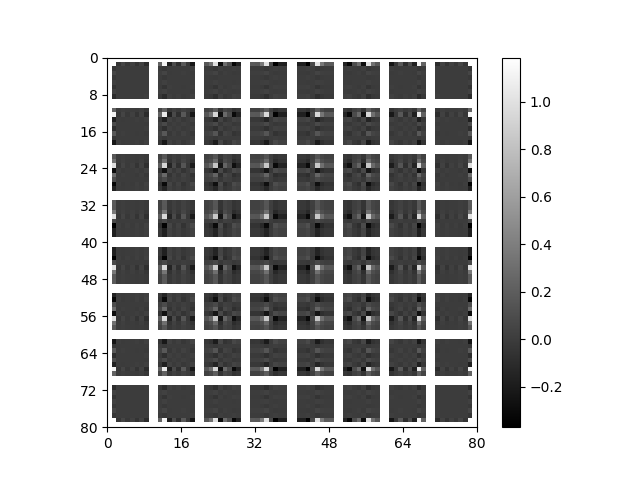

In [13]:
Pf, Pr = pot_ii(8)
bases = np.concatenate([np.full((8,1), np.nan), Pf, np.full((8,1), np.nan)], axis=1)
bases = bases.reshape(-1, 1)
fig, ax = plt.subplots()
im_obj = plot_image(bases @ bases.T, ax=ax)
fig.colorbar(im_obj, ax=ax);

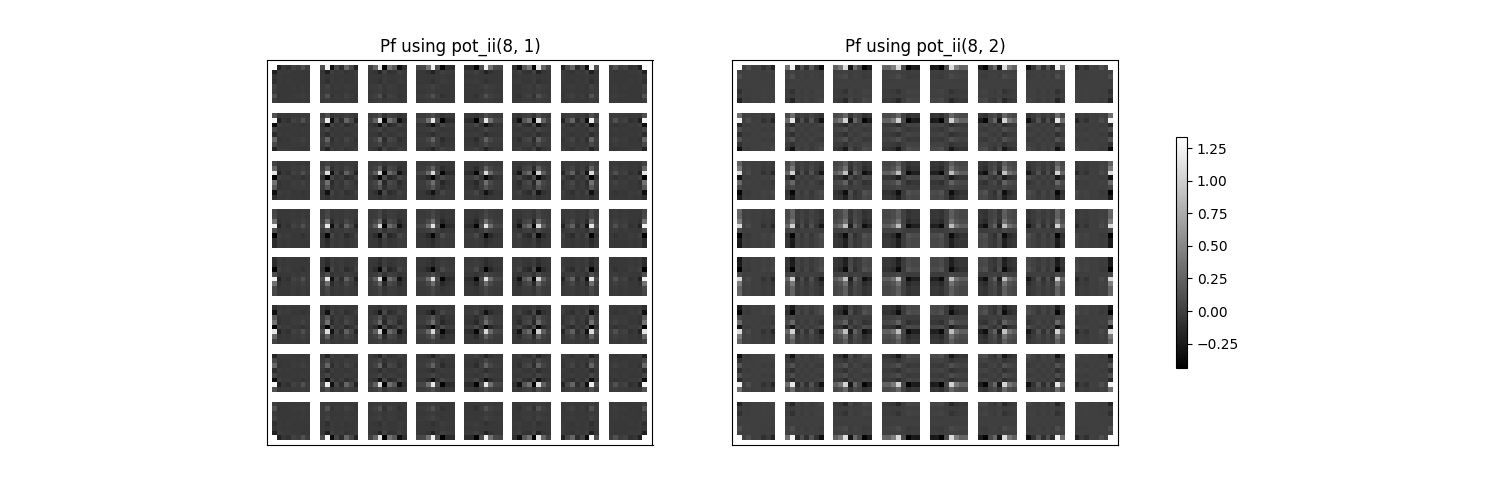

In [14]:
def plot_image(data, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    im_obj = ax.imshow(data, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    return im_obj

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot for pot_ii(8, 1)
Pf, Pr = pot_ii(8, 1)
bases = np.concatenate([np.full((8, 1), np.nan), Pf, np.full((8, 1), np.nan)], axis=1)
bases = bases.reshape(-1, 1)
im_obj = plot_image(bases @ bases.T, ax=axs[0])
axs[0].set_title('Pf using pot_ii(8, 1)')

# Plot for pot_ii(8, 2)
Pf, Pr = pot_ii(8, 2)
bases = np.concatenate([np.full((8, 1), np.nan), Pf, np.full((8, 1), np.nan)], axis=1)
bases = bases.reshape(-1, 1)
im_obj = plot_image(bases @ bases.T, ax=axs[1])
axs[1].set_title('Pf using pot_ii(8, 2)')

fig.subplots_adjust(wspace=0.0)
fig.colorbar(im_obj, ax=axs.ravel().tolist(), shrink=0.6)
plt.show()

The above colour map shows how the POT modifies the middle of the block the most, which becomes the edges of the DCT blocks. Each 8x8 block in the above colour map shows how each pixel in the 8x8 output of the POT transform is dependent on the other pixels in this 8x8 block. This colour map is generated by doing the outer product of each POT basis row with each POT basis column. 8 basis rows and 8 basis columns so 64 possible 8x8 matrices formed from the outer products as shown in colour map. 

Makes sense that we want to modify the middle of the block the most because this is where edge effects will be taking place in the DCT. The edges of the POT block are in the middle of the DCT block so we don't need to make them so dependent on other pixels towards the middle of the block - however, we do smooth them over that edge.

<div class="alert alert-block alert-danger">

Look at both these bases and the pre-filtered image `Xp`, using different scaling factors
`s`, and comment on the visual effect of varying these scaling factors. You may need to
multiply `Xp` by up to 0.5 to display it better.</div>

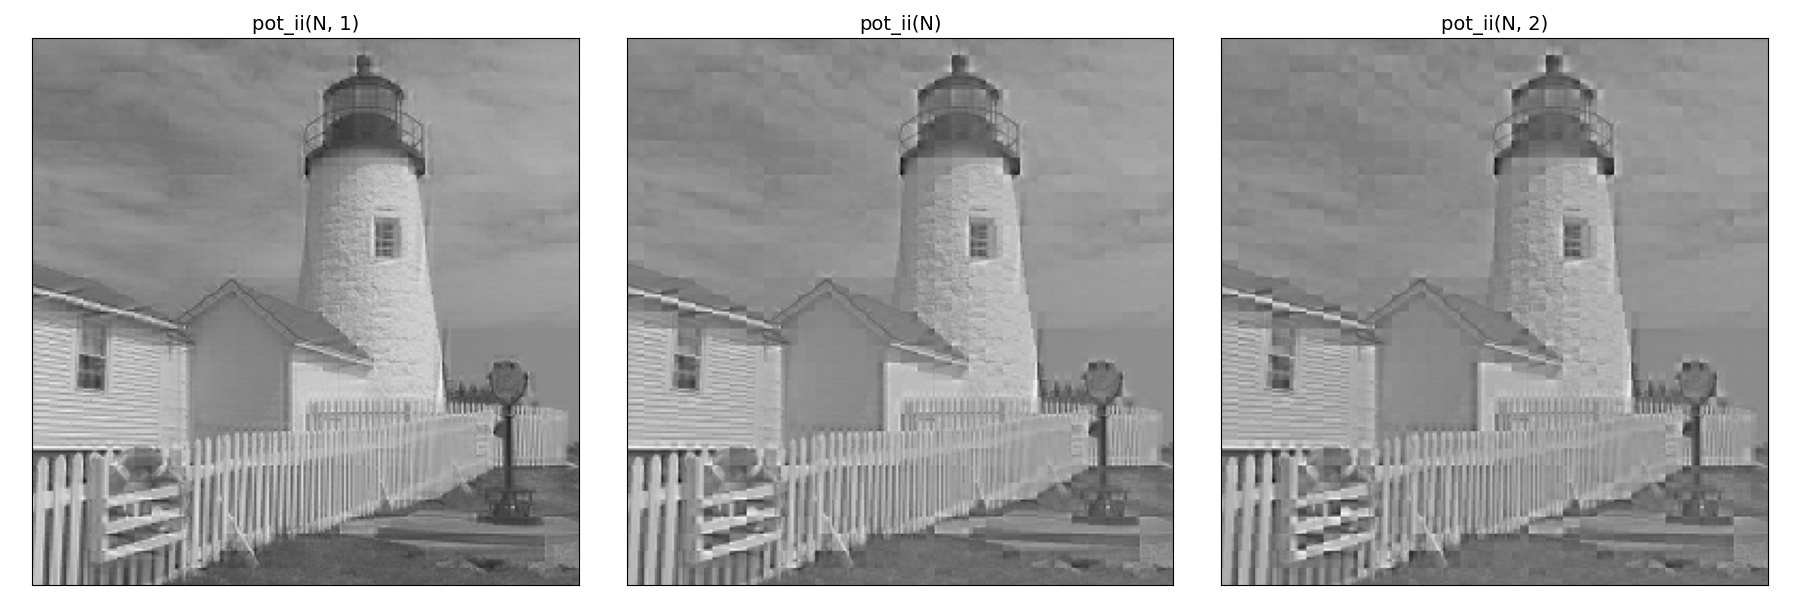

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Increased figsize

# Plot for pot_ii(N, 1)
Pf, Pr = pot_ii(N, 1)
t = np.s_[N//2:-N//2]
Xp_1 = X.copy()
Xp_1[t, :] = colxfm(Xp_1[t, :], Pf)
Xp_1[:, t] = colxfm(Xp_1[:, t].T, Pf).T
plot_image(Xp_1, ax=axs[0])
axs[0].set_title('pot_ii(N, 1)', fontsize=14)  # Increased font size
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot for pot_ii(N)
Pf, Pr = pot_ii(N)
t = np.s_[N//2:-N//2]
Xp_2 = X.copy()
Xp_2[t, :] = colxfm(Xp_2[t, :], Pf)
Xp_2[:, t] = colxfm(Xp_2[:, t].T, Pf).T
plot_image(Xp_2, ax=axs[1])
axs[1].set_title('pot_ii(N)', fontsize=14)
axs[1].set_xticks([])
axs[1].set_yticks([])

# Plot for pot_ii(N, 2)
Pf, Pr = pot_ii(N, 2)
t = np.s_[N//2:-N//2]
Xp_3 = X.copy()
Xp_3[t, :] = colxfm(Xp_3[t, :], Pf)
Xp_3[:, t] = colxfm(Xp_3[:, t].T, Pf).T
plot_image(Xp_3, ax=axs[2])
axs[2].set_title('pot_ii(N, 2)', fontsize=14)
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.subplots_adjust(bottom=0.2)  # Increased bottom spacing
plt.tight_layout()
plt.show()

Pretty clearly more pre-filtering going on when use a larger scaling factor - as would expect!

With this type of POT / DCT combination it is common to use smaller DCT block sizes
but to code several blocks together. Hence a more accurate estimate of the number of bits
is found by always using 16 × 16 blocks, i.e. regroup `Yq` with the correct size `N` to give
`Yr`, but then always use `dctbpp(Yr, 16)`.

<div class="alert alert-block alert-danger">

Investigate the relative visual and compression performance of LBTs with 4 × 4, 8 × 8
and 16 × 16 blocks, using the scaling factor you have previously selected. As before, be
careful to match the rms error with a directly quantised image.</div>

Assume root(2) is the optimum scaling factor for maximising the compression ratio since this is what we found for the 8x8 block!

28.857421875 25.927734375 22.939453125
3.5637449837319344 3.4208320876226495 2.9439148029565723


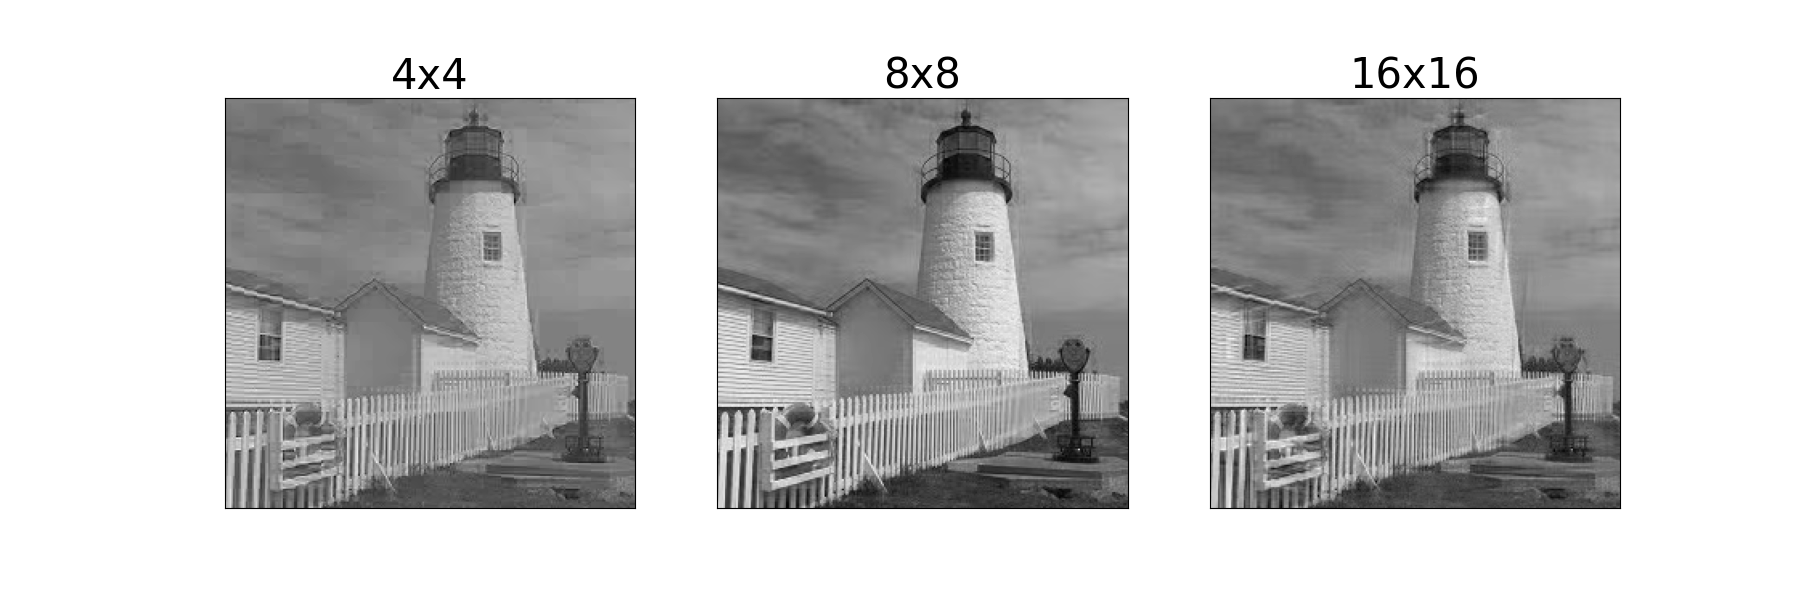

In [16]:
# your code here
"""
1 Calculate the quantisation step size that gives same rms error as directly quantised image
2 Regroup Yq with corresponding size N to give Yr and then find entropy ALWAYS using dctbpp(Yr, 16)
3 Calculate compression ratio
4 Decode and plot images side by side, with compression ratios as captions


"""
s = np.sqrt(2)
X_quant = quantise(X, 17)
X_quant_ent = bpp(X_quant) * X_quant.size

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Define the DCT matrices
C4 = dct_ii(4)
C8 = dct_ii(8)
C16 = dct_ii(16)

# Process for C4
step_size_4 = find_step_equal_rms(X, C4, s)
Yq_4 = gen_Y_quant_lbt(X, step_size_4, C4, s)
Yr_4 = regroup(Yq_4, 4)
Yr_4_ent = dctbpp(Yr_4, 16)
comp_ratio_4 = X_quant_ent / Yr_4_ent

Z_4 = colxfm(colxfm(Yq_4.T, C4.T).T, C4.T)
Zp_4 = Z_4.copy()
Zp_4[:,t] = colxfm(Zp_4[:,t].T, Pr.T).T
Zp_4[t,:] = colxfm(Zp_4[t,:], Pr.T)
plot_image(Zp_4, ax=axs[0])

# Process for C8
step_size_8 = find_step_equal_rms(X, C8, s)
Yq_8 = gen_Y_quant_lbt(X, step_size_8, C8, s)
Yr_8 = regroup(Yq_8, 8)
Yr_8_ent = dctbpp(Yr_8, 16)
comp_ratio_8 = X_quant_ent / Yr_8_ent

Z_8 = colxfm(colxfm(Yq_8.T, C8.T).T, C8.T)
Zp_8 = Z_8.copy()
Zp_8[:,t] = colxfm(Zp_8[:,t].T, Pr.T).T
Zp_8[t,:] = colxfm(Zp_8[t,:], Pr.T)
plot_image(Zp_8, ax=axs[1])

# Process for C16
step_size_16 = find_step_equal_rms(X, C16, s)
Yq_16 = gen_Y_quant_lbt(X, step_size_16, C16, s)
Yr_16 = regroup(Yq_16, 16)
Yr_16_ent = dctbpp(Yr_16, 16)
comp_ratio_16 = X_quant_ent / Yr_16_ent

Z_16 = colxfm(colxfm(Yq_16.T, C16.T).T, C16.T)
Zp_16 = Z_16.copy()
Zp_16[:,t] = colxfm(Zp_16[:,t].T, Pr.T).T
Zp_16[t,:] = colxfm(Zp_16[t,:], Pr.T)
plot_image(Zp_16, ax=axs[2])

axs[0].set_title('4x4', fontsize=30)
axs[1].set_title('8x8', fontsize=30)
axs[2].set_title('16x16', fontsize=30)

print(step_size_4, step_size_8, step_size_16)
print(comp_ratio_4, comp_ratio_8, comp_ratio_16)
